# Выпускной проект "Прогнозирование оттока клиентов". Доменная область - Телеком

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Задачи проекта

1. Получить и проанализировать данные клиентов телекоммуникационной компании (информация о договорах, персональные данные, информация об услугах интернет и телефонии.
2. Объединить полученные данные, обработать их и подготовить к обучению моделей.
3. Разделить данные на обучающую и тестовую выборку и обучить несколько моделей классификации.
4. Оценить качество и скорость работы моделей.
5. Выбрать лучшую модель, сделать предсказания на тестовой выборке, сделать выводы.

### Цель проекта

Обучить модель предсказывать отток клиентов. Цель работы будет достигнута при достижении моделью точности по метрике ROC-AUC не ниже 0.85.

## Исследовательский анализ данных

In [2]:
# импорт библиотек
from functools import reduce
import time

import pandas as pd
import matplotlib.pyplot as plt
import phik
import lightgbm as lgb
import numpy as np

from phik.report import plot_correlation_matrix
from phik import report
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score
)
from sklearn.metrics import (
    roc_auc_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

# обозначим константы
RANDOM_STATE = 240423

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

In [3]:
# загрузка данных
contract_df = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
personal_df = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
internet_df = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
phone_df = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

### Анализ отдельных файлов

Посмотрим на данные:

``contract_df``

In [4]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [6]:
contract_df.tail()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8
7042,3186-AJIEK,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,7251.82


Посмотрим на значения в столбце ``EndDate``:

In [7]:
contract_df['EndDate'].value_counts().head()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
Name: EndDate, dtype: int64

Так как впоследствии мы планируем объединить файлы по столбцу ``customerID``, убедимся, что в нем нет повторов:

In [8]:
print('Количество повторяющихся значений в столбце customerID:', 
      contract_df['customerID'].duplicated().sum())

Количество повторяющихся значений в столбце customerID: 0


Пропуски отсутствуют; в столбцах ``BeginDate`` и ``EndDate`` тип данных нужно заменить на ``datetime``; повторы в ``customerID`` отсутствуют.

___

``personal_df``

In [9]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [10]:
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Также посмотрим на количество повторов в столбце ``customerID``:

In [11]:
print('Количество повторяющихся значений в столбце customerID:', 
      personal_df['customerID'].duplicated().sum())

Количество повторяющихся значений в столбце customerID: 0


Пропуски отсутствуют; количество столбцов совпадает с количеством в файле ``contract``; повторы в ``customerID`` отсутствуют.

___

``internet_df``

In [12]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [13]:
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Количество строк меньше, чем в предыдущих файлах.

Поверим столбец ``customerID`` на уникальность:

In [14]:
print('Количество уникальных значений столбца customerID:', 
      internet_df['customerID'].nunique())

Количество уникальных значений столбца customerID: 5517


В данном файле количество уникальных пользователей меньше, чем в двух предыдущих. Это может быть связано с тем, что не все клиенты пользуются услугами интернета.

___

``phone_df``

In [15]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [16]:
phone_df.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Проверим количество уникальных значений в столбце ``customerID``:

In [17]:
print('Количество уникальных значений столбца customerID:', 
      phone_df['customerID'].nunique())

Количество уникальных значений столбца customerID: 6361


Количество пользователей в данном файле также меньше, чем в ``contract_new`` и ``personal_new``, что связано с тем, что не все пользователи используют услуги телефонии.

___

### Объединение файлов

Объединим все файлы по столбцу ``customerID``. Т. к. нам необходимо сохранить всех пользователей из файлов ``contract_new`` и ``personal_new``, используем тип объединения ``outer``.

In [18]:
df = reduce(lambda left, right: pd.merge(left, right, on=['customerID'],
                                         how='outer'), [contract_df, personal_df, internet_df, phone_df])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [20]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Объединение успешно, количество пользователей совпадает с количеством в файле ``contract_new``.

В результате объединения в столбцах, связанных с услугами интернета и телефонии, появились пропуски. Заполним их на этапе подготовки данных к обучению модели.

### Анализ сводного датафрейма

Также проверим минимальное и максимальное значения в столбцах ``BeginDate`` и ``EndDate``.

In [21]:
print('Диапазон данных в столбце BeginDate:', 
      df['BeginDate'].min(), 
      '-', 
      df['BeginDate'].max())

Диапазон данных в столбце BeginDate: 2013-10-01 - 2020-02-01


Диапазон начала действия договора не вызывает вопросов, т. к. по условиям данные актуальны на 1 февраля 2020 года.

In [22]:
print('Диапазон данных в столбце EndDate:', 
      df['EndDate'].min(), 
      '-', 
      df['EndDate'].value_counts().sort_values().index[-2]) # исключаем значение 'No', которое берется как максимальное

Диапазон данных в столбце EndDate: 2014-06-01 - 2020-01-01


В этом столбце также нет значений, превышающих дату выгрузки данных.

На основе данного столбца мы создадим целевой признак, где значения ``No`` будут означать, что клиент продолжает сотрудничество с компанией, а значение даты говорит о том, что клиент уже ушел.

### Вывод по EDA

#### Список уточняющих вопросов

Вопросы, возникшие в процессе EDA, были прояснены на встрече с тимлидом. Дополнительные вопросы отсутствуют.

#### План решения задачи

1. Обработать сводный датасет и подготовить его к обучению модели.
2. Выбрать столбцы (параметры), актуальные для обучения модели, при необходимости создать новые.
3. Разделить данные на обучающую и тестовую выборки. 
4. Обучить несколько моделей классификации и сравнить их показатели на кросс-валидации по обучающей выборке.
5. Выбрать лучшую модель, проверить ее качество на тестовой выборке и представить результаты.

### Цель проекта

Обучить модель предсказывать отток клиентов со значением метрики ROC-AUC не ниже 0.85.

## Предобработка данных

Выведем еще раз информацию по сводному датафрейму:

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [24]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


В рамках предобработки нужно выполнить следующие шаги:
1. Заполнить пропуски в данных.
2. Выделить целевой признак и проверить его на дисбаланс классов.
3. Создать при необходимости новые признаки.
4. Проверить признаки на мультиколлинеарность.
5. Выбрать необходимые для обучения модели признаки.

### Заполнение пропусков и изменение формата данных

Выведем информацию о явных пропусках:

In [25]:
print('Явные пропуски до обработки')
df.isna().sum()

Явные пропуски до обработки


customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Т. к. выявленные пропуски связаны с тем, что не все клиенты пользуются услугами интернета и телефонии, заполним их отдельным значением ``not_used``.

In [26]:
df = df.fillna('not_used')

In [27]:
# проверка заполнения пропусков
print('Явные пропуски после обработки')
df.isna().sum()

Явные пропуски после обработки


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

___

Теперь посмотрим на значения в каждом из столбцов датафрейма с помощью метода ``value_counts``:

In [28]:
for column in df.columns:
    print(column)
    print(df[column].value_counts().sort_values(ascending=False))
    print()

customerID
7590-VHVEG    1
0280-XJGEX    1
7795-CFOCW    1
9237-HQITU    1
9305-CDSKC    1
             ..
2234-XADUH    1
4801-JZAZL    1
8361-LTMKD    1
1122-JWTJW    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

BeginDate
2014-02-01    366
2019-09-01    237
2019-10-01    237
2019-11-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64

EndDate
No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: EndDate, Length: 67, dtype: int64

Type
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

PaperlessBilling
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

PaymentMethod
Electronic check             2365
Mailed check                 16

Мы видим потенциальные пропуски в столбце ``TotalCharges``.

Удалим строки с пропущенными значениями (т. к. истинное значение нам неизвестно, а количество пропусков составляет небольшую часть от общего числа значений. Мы не ожидаем существенного влияния на конечный результат.).

In [29]:
df = df.drop(df[df['TotalCharges'] == ' '].index)

Переведем столбец в верный формат:

In [30]:
df['TotalCharges'] = df['TotalCharges'].astype('float')

Посмотрим еще раз на обработанный столбец:

In [31]:
df['TotalCharges'].value_counts().sort_index()

19.05      1
19.10      2
19.19      1
19.20      3
19.30      1
          ..
8957.52    1
8998.27    1
9068.36    1
9218.88    1
9221.38    1
Name: TotalCharges, Length: 6657, dtype: int64

Также посмотрим на распределение значений в столбцах ``TotalCharges`` и ``MonthlyCharges``:

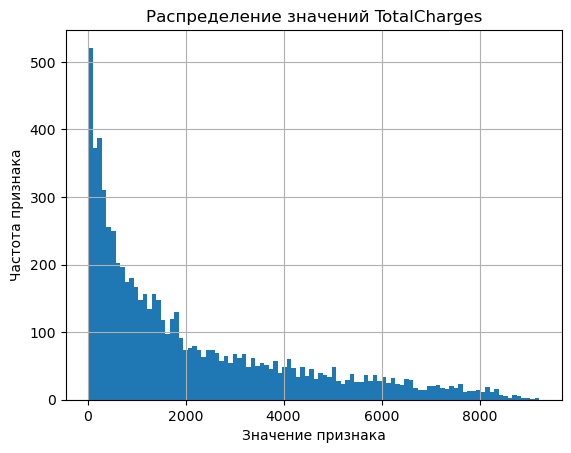

In [32]:
df['TotalCharges'].hist(bins=100)
plt.title('Распределение значений TotalCharges')
plt.xlabel('Значение признака')
plt.ylabel('Частота признака')
plt.show()

Мы видим, что распределение выглядит правдоподобно с пиком возле низких значений и постепенно снижающейся частотой по мере увеличения общей суммы выплат.

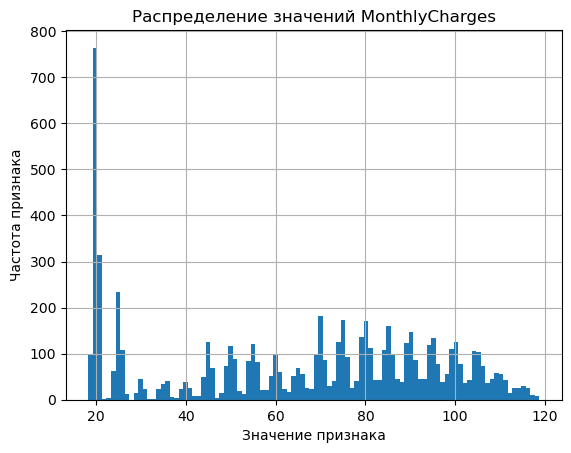

In [33]:
df['MonthlyCharges'].hist(bins=100)
plt.title('Распределение значений MonthlyCharges')
plt.xlabel('Значение признака')
plt.ylabel('Частота признака')
plt.show()

Распределение значений неоднородно с пиками возле определенных значений и небольшими отклонениями от них. Можно предположить, что пики представляют собой стандартные наборы услуг в рамках определенного тарифа, а окружающие их значения - доплату или скидку за их изменение либо в силу прочих факторов.

Также присутствует основной пик возле значения 20. Посмотрим на него подробнее:

In [34]:
print('Распределение клиентов по использованию интернета, ежемесячный платеж которых составляет менее 25 долларов')
df[df['MonthlyCharges'] < 25]['InternetService'].value_counts()

Распределение клиентов по использованию интернета, ежемесячный платеж которых составляет менее 25 долларов


not_used    1346
DSL           39
Name: InternetService, dtype: int64

Мы видим, что пик возле размера платежа в 20 долларов обусловлен тем, что данные клиенты не используют услуги интернета.

Также посмотрим, сколько платят пользователи, которые не пользуются ни интернетом, ни телефоном:

In [35]:
df[(df['InternetService'] == 'not_used') & (df['MultipleLines'] == 'not_used')]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines


Такие клиенты отсутствуют. Проверим, посмотрев на распределение параметра ``MultipleLines`` у клиентов, не использующих интернет:

In [36]:
df[(df['InternetService'] == 'not_used')]['MultipleLines'].value_counts()

No     1180
Yes     340
Name: MultipleLines, dtype: int64

Значение ``No`` означает, что данные пользователи не используют несколько линий, однако телефон у всех таких клиентов есть.

___

### Выделение целевого признака

Создадим целевой признак на основе столбца ``EndDate``. Ушедший клиент будет обозначен на основе значения ``No`` (что означает отсутствие даты завершения контракта), а значение даты будет означать, что договор с клиентом действителен.

In [37]:
df.loc[df['EndDate'] == 'No', 'Churn'] = 1
df.loc[df['EndDate'] != 'No', 'Churn'] = 0
df['Churn'] = df['Churn'].astype('int')

Посмотрим на распределение целевого признака:

In [38]:
df['Churn'].value_counts()

1    5931
0    1101
Name: Churn, dtype: int64

Сравним с количеством ``No`` в столбце ``EndDate``:

In [39]:
(df['EndDate'] == 'No').sum()

5931

Количество совпадает, целевой столбец сознан верно.

В то же время мы видим дисбаланс классов - число уже ушедших клиентов существенно больше. Однако, в связи с тем что в качестве целевой метрики мы используем ROC-AUC, которая не подвержена влиянию дисбаланса классов, корректировать дисбаланс необходимости нет.

___

### Создание новых признаков

Также создадим новый признак на основе столбцов ``BeginDate`` и ``EndDate``, обозначающий количество дней, которое пользователь был (либо является) клиентом компании.

In [40]:
# заполним значения 'No' датой выгрузки датасета
df.loc[df['EndDate'] == 'No', 'EndDate'] ='2020-02-01'

Далее скорректируем формат данных у столбцов:

In [41]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d')

Создадим столбец ``ContractDuration``:

In [42]:
df['ContractDuration'] = df['EndDate'] - df['BeginDate']
df['ContractDuration'] = df['ContractDuration'].dt.days # конвертируем количество дней в формат int

Посмотрим на распределение:

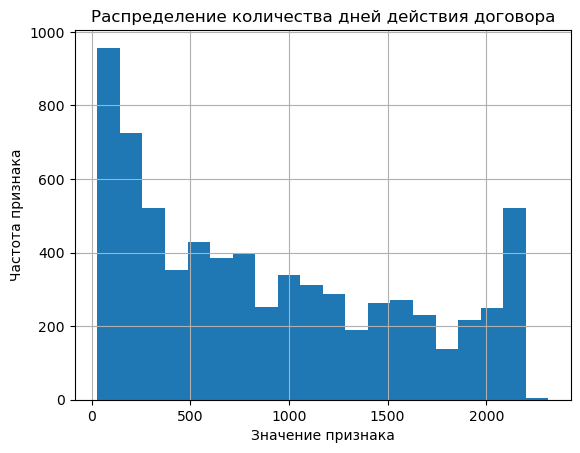

In [43]:
df['ContractDuration'].hist(bins=20)
plt.title('Распределение количества дней действия договора')
plt.xlabel('Значение признака')
plt.ylabel('Частота признака')
plt.show()

На графике виден пик после 2000 дней действия договора. Посмотрим на параметр ``TotalCharges`` у таких клиентов, чтобы оценить достоверность значений:

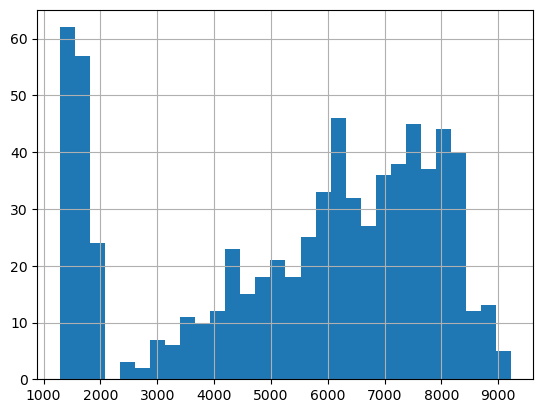

In [44]:
df[df['ContractDuration']>2000]['TotalCharges'].hist(bins=30)
plt.show()

Мы видим, что у многих клиентов из этой категории общая уплаченная сумма меньше 2000 долларов. Рассмотрим таких клиентов подробнее. Посчитаем среднюю ежемесячную плату по данным клиентам.

In [45]:
df[(df['ContractDuration'] > 2000) & (df['TotalCharges'] < 2000)]['MonthlyCharges'].mean()

22.743706293706285

In [46]:
print('Расчетная сумма за 2000 дней:', 22.74 / 30 * 2000)

Расчетная сумма за 2000 дней: 1515.9999999999998


Мы видим, что сумма выглядит правдоподобно. Она может связана с тем, что данные клиенты пользуются самым дешевым тарифом.

___

### Анализ признаков

Также исследуем признаки в разрезе ушедших/оставшихся клиентов:

In [47]:
# напишем функцию для анализа качественных признаков
def left_actual_df_cat(df, column):
    left = df[df['Churn'] == 1][column].value_counts().values
    actual = df[df['Churn'] == 0][column].value_counts().values
    df = pd.DataFrame(index=df[column].unique(), data={'Ушедший клиент': left, 
                                                          '% от ушедших': np.round(left / left.sum(), 2),
                                                          'Действующий клиент': actual, 
                                                          '% от действующих': np.round(actual / actual.sum(), 2)})
    df.index.name = column
    return df

``Type``

In [48]:
left_actual_df_cat(df, 'Type')

,Ушедший клиент,% от ушедших,Действующий клиент,% от действующих
Type,,,,
Month-to-month,3468,0.58,407,0.37
One year,1304,0.22,381,0.35
Two year,1159,0.20,313,0.28


Мы видим, что у ушедших клиентов преобладает помесячный тип оплаты, в то время как у действующих тип распределен более равномерно. 

``PaperlessBilling``

In [49]:
left_actual_df_cat(df, 'PaperlessBilling')

,Ушедший клиент,% от ушедших,Действующий клиент,% от действующих
PaperlessBilling,,,,
Yes,3447,0.58,721,0.65
No,2484,0.42,380,0.35


Соотношение типа платежного документа примерно одинаковое: электронных больше в обеих группах.

``PaymentMethod``

In [50]:
left_actual_df_cat(df, 'PaymentMethod')

,Ушедший клиент,% от ушедших,Действующий клиент,% от действующих
PaymentMethod,,,,
Electronic check,2015,0.34,350,0.32
Mailed check,1487,0.25,317,0.29
Bank transfer (automatic),1225,0.21,317,0.29
Credit card (automatic),1204,0.20,117,0.11


Способ оплаты в двух группах различается незначительно: у действующих клиентов меньшая доля автоматической оплаты с карты.

``gender``

In [51]:
left_actual_df_cat(df, 'gender')

,Ушедший клиент,% от ушедших,Действующий клиент,% от действующих
gender,,,,
Female,2976,0.5,573,0.52
Male,2955,0.5,528,0.48


Различий по полу практически нет.

``SeniorCitizen``

In [52]:
left_actual_df_cat(df, 'SeniorCitizen')

,Ушедший клиент,% от ушедших,Действующий клиент,% от действующих
SeniorCitizen,,,,
0,5021,0.85,869,0.79
1,910,0.15,232,0.21


Доля пенсионеров также сопоставима.

``Partner``

In [53]:
left_actual_df_cat(df, 'Partner')

,Ушедший клиент,% от ушедших,Действующий клиент,% от действующих
Partner,,,,
Yes,3257,0.55,719,0.65
No,2674,0.45,382,0.35


Доля замужних клиентов чуть выше у действующих.

``Dependents``

In [54]:
left_actual_df_cat(df, 'Dependents')

,Ушедший клиент,% от ушедших,Действующий клиент,% от действующих
Dependents,,,,
No,4200,0.71,733,0.67
Yes,1731,0.29,368,0.33


Доля клиентов, имеющих иждивенцев, практически одинакова.

``InternetService``

In [55]:
left_actual_df_cat(df, 'InternetService')

,Ушедший клиент,% от ушедших,Действующий клиент,% от действующих
InternetService,,,,
DSL,2501,0.42,595,0.54
Fiber optic,2070,0.35,346,0.31
not_used,1360,0.23,160,0.15


В группе действующих клиентов доля DSL чуть выше, также больше клиентов пользуется интернетом.

``OnlineSecurity``

In [56]:
left_actual_df_cat(df, 'OnlineSecurity')

,Ушедший клиент,% от ушедших,Действующий клиент,% от действующих
OnlineSecurity,,,,
No,2971,0.50,526,0.48
Yes,1600,0.27,415,0.38
not_used,1360,0.23,160,0.15


В группе действующих клиентов услуга блокировки небезопасных сайтов более популярна.

``OnlineBackup``

In [57]:
left_actual_df_cat(df, 'OnlineBackup')

,Ушедший клиент,% от ушедших,Действующий клиент,% от действующих
OnlineBackup,,,,
Yes,2706,0.46,560,0.51
No,1865,0.31,381,0.35
not_used,1360,0.23,160,0.15


``DeviceProtection``

In [58]:
left_actual_df_cat(df, 'DeviceProtection')

,Ушедший клиент,% от ушедших,Действующий клиент,% от действующих
DeviceProtection,,,,
No,2703,0.46,550,0.50
Yes,1868,0.31,391,0.36
not_used,1360,0.23,160,0.15


Популярность услуги "Облачное хранилище файлов для резервного копирования данных" и антивируса сопоставима в обеих группах.

``TechSupport``

In [59]:
left_actual_df_cat(df, 'TechSupport')

,Ушедший клиент,% от ушедших,Действующий клиент,% от действующих
TechSupport,,,,
No,2929,0.49,543,0.49
Yes,1642,0.28,398,0.36
not_used,1360,0.23,160,0.15


Услугой выделенной линии технической поддержки чаще пользуются действующие клиенты.

``StreamingTV``

In [60]:
left_actual_df_cat(df, 'StreamingTV')

,Ушедший клиент,% от ушедших,Действующий клиент,% от действующих
StreamingTV,,,,
No,2452,0.41,584,0.53
Yes,2119,0.36,357,0.32
not_used,1360,0.23,160,0.15


``StreamingMovies``

In [61]:
left_actual_df_cat(df, 'StreamingMovies')

,Ушедший клиент,% от ушедших,Действующий клиент,% от действующих
StreamingMovies,,,,
No,2446,0.41,606,0.55
Yes,2125,0.36,335,0.30
not_used,1360,0.23,160,0.15


Услуги, связанные со стриминговым телевидением, были популярнее у ушедших клиентов.

``MultipleLines``

In [62]:
left_actual_df_cat(df, 'MultipleLines')

,Ушедший клиент,% от ушедших,Действующий клиент,% от действующих
MultipleLines,,,,
not_used,3065,0.52,678,0.62
No,2289,0.39,320,0.29
Yes,577,0.10,103,0.09


Среди действующих клиентов телефонные услуги менее популярны, также реже встречается возможность использования нескольких линий.

In [63]:
# функция для анализа количественных признаков
def left_actual_df_cat_num(df, column):
    left = df[df['Churn'] == 1][column].values
    actual = df[df['Churn'] == 0][column].values
    df = pd.DataFrame(index=['min', 'max', 'avg'], data={'Ушедший клиент': [round(left.min(),2), 
                                                                            round(left.max(),2), 
                                                                            round(left.mean(), 2)], 
                                                          'Действующий клиент': [round(actual.min(), 2),
                                                                                 round(actual.max(), 2), 
                                                                                 round(actual.mean(), 2)]})
    df.index.name = column
    return df

``MonthlyCharges``

In [64]:
left_actual_df_cat_num(df, 'MonthlyCharges')

,Ушедший клиент,Действующий клиент
MonthlyCharges,,
min,18.25,18.40
max,118.60,118.75
avg,62.80,75.55


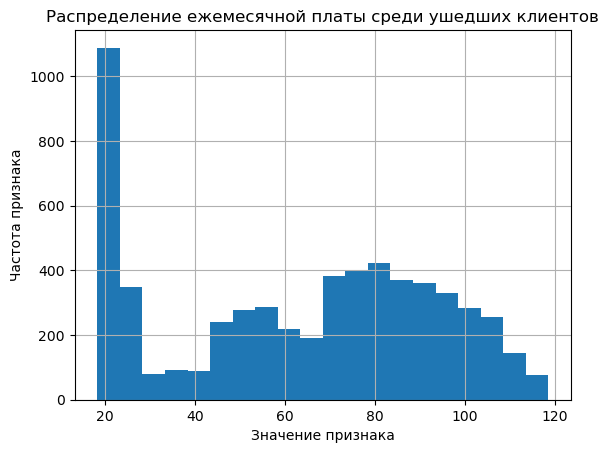

In [65]:
left = df[df['Churn'] == 1]['MonthlyCharges'].hist(bins=20)
plt.title('Распределение ежемесячной платы среди ушедших клиентов')
plt.xlabel('Значение признака')
plt.ylabel('Частота признака')
plt.show()

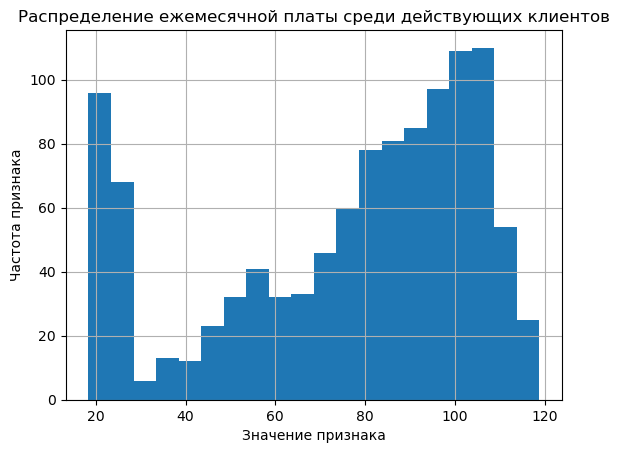

In [66]:
left = df[df['Churn'] == 0]['MonthlyCharges'].hist(bins=20)
plt.title('Распределение ежемесячной платы среди действующих клиентов')
plt.xlabel('Значение признака')
plt.ylabel('Частота признака')
plt.show()

Мы видим, что минимальные и средние платежи распределены примерно одинаково у ушедших и действующих клиентов, однако среди действующих клиентов гораздо больше тех, кто платит больше 70 долларов в месяц.

``TotalCharges``

In [67]:
left_actual_df_cat_num(df, 'TotalCharges')

,Ушедший клиент,Действующий клиент
TotalCharges,,
min,19.05,77.84
max,9221.38,7649.76
avg,2071.70,2371.38


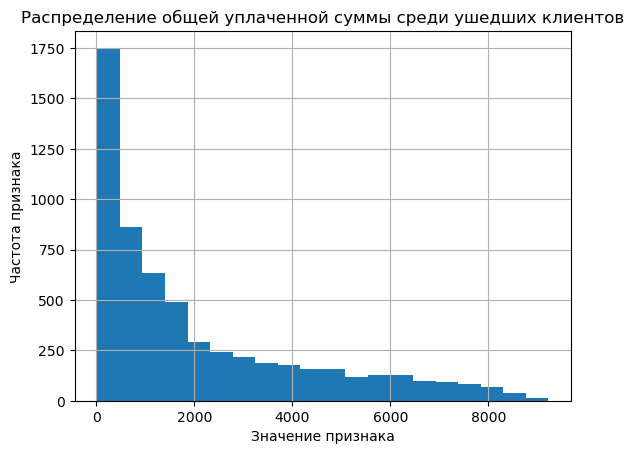

In [68]:
left = df[df['Churn'] == 1]['TotalCharges'].hist(bins=20)
plt.title('Распределение общей уплаченной суммы среди ушедших клиентов')
plt.xlabel('Значение признака')
plt.ylabel('Частота признака')
plt.show()

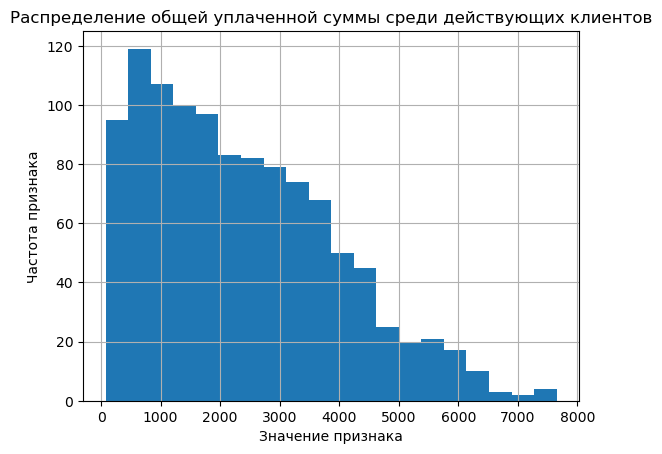

In [69]:
left = df[df['Churn'] == 0]['TotalCharges'].hist(bins=20)
plt.title('Распределение общей уплаченной суммы среди действующих клиентов')
plt.xlabel('Значение признака')
plt.ylabel('Частота признака')
plt.show()

В то время как минимальные и максимальные значения общей уплаченной суммы в разрезе категорий клиентов схожи, средняя сумма всех платежей у ушедших клиентов меньше, что связано с тем, что среди действующих клиентов гораздо больше клиентов с общей суммой платежа более 1000 долларов, что опять же можно связать с большим ежемесячным платежом в среднем.

``ContractDuration``

In [70]:
left_actual_df_cat_num(df, 'ContractDuration')

,Ушедший клиент,Действующий клиент
ContractDuration,,
min,31.00,28.00
max,2314.00,2129.00
avg,895.34,924.86


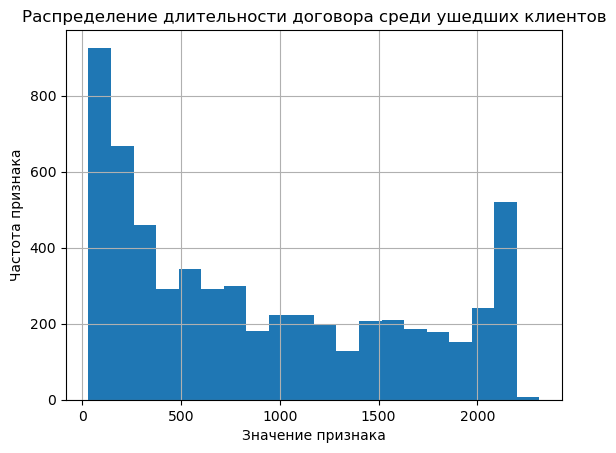

In [71]:
left = df[df['Churn'] == 1]['ContractDuration'].hist(bins=20)
plt.title('Распределение длительности договора среди ушедших клиентов')
plt.xlabel('Значение признака')
plt.ylabel('Частота признака')
plt.show()

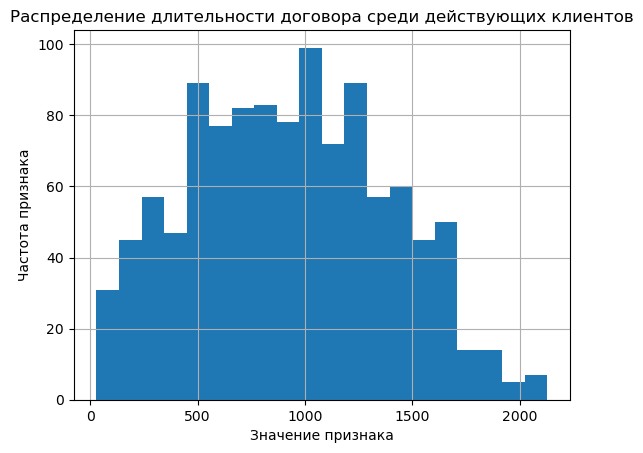

In [72]:
left = df[df['Churn'] == 0]['ContractDuration'].hist(bins=20)
plt.title('Распределение длительности договора среди действующих клиентов')
plt.xlabel('Значение признака')
plt.ylabel('Частота признака')
plt.show()

Мы видим, что средний срок действия контракта у действующих клиентов чуть больше, однако незначительно.
При этом распределения срока действия прямо противоположные. Исходя из графиков, клиенты уходят либо почти сразу (в течение одного-полутора лет) либо после 2000 дней пользования услугами компании. В то же время между этими значениями большинство клиентов являются действующими.

#### Вывод

По результатам анализа наибольшие различия значений между ушедшими и действующими клиентами выявлены среди признаков ежемесячного платежа и общей суммы платежа, а также срока действия договора с клиентом.

### Проверка корреляции признаков

Удалим признак ``EndDate``, т. к. он использовался для создания целевого признака.

In [73]:
df = df.drop(columns='EndDate')

Корреляцию будем оценивать с помощью 'Phi-k' корреляции, способную работать с категориальными и порядковыми переменными, а также улавливающую нелинейную зависимость.

In [74]:
# отберем признаки, которые будем анализировать
columns_to_analize = ['BeginDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines', 'Churn', 'ContractDuration']
# укажем интервальные признаки
interval_columns = ['MonthlyCharges', 'TotalCharges', 'ContractDuration']
# построим матрицу корреляции
phik_overview = df[columns_to_analize].phik_matrix(interval_cols=interval_columns)

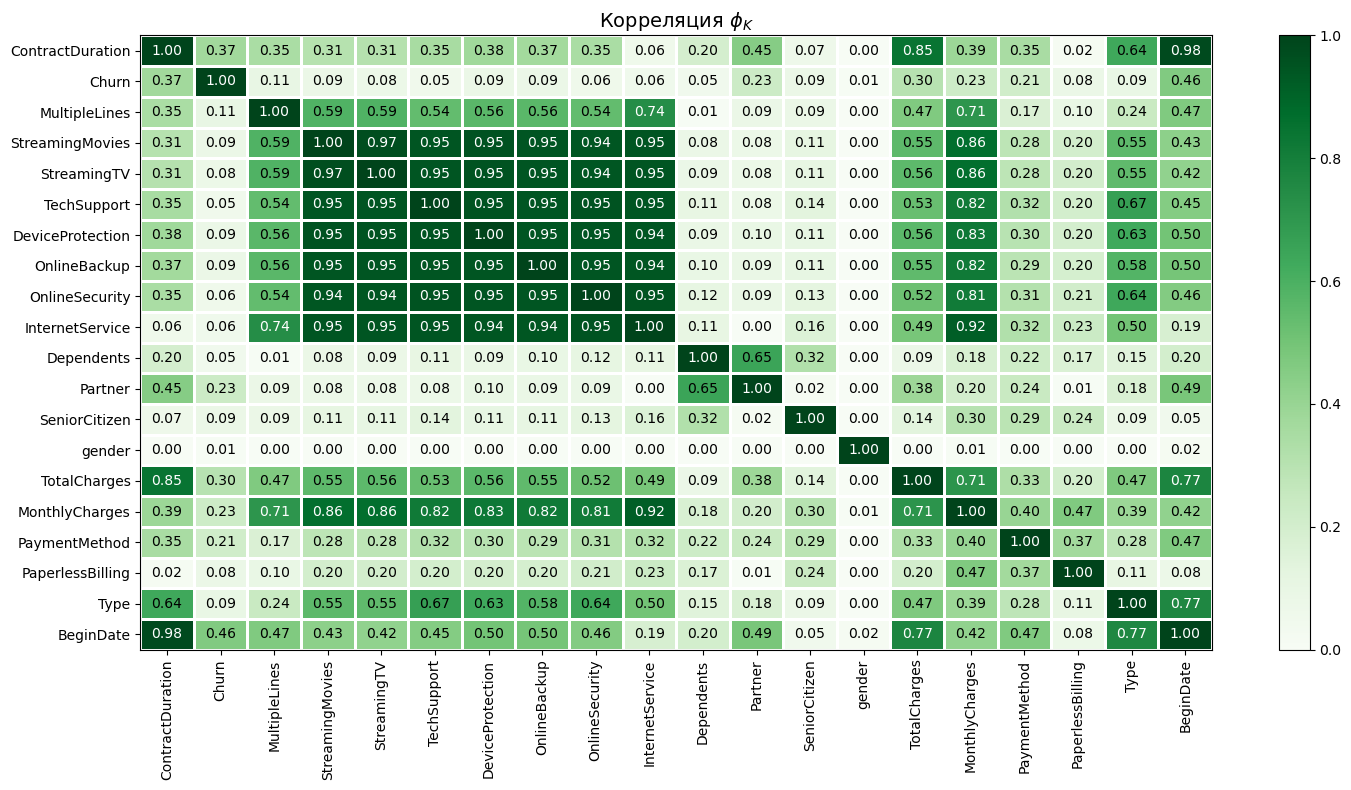

In [75]:
# построим тепловой график корреляции
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 8))
plt.tight_layout()

Мы видим, что существует высокая корреляция между признаками:
1. ``ContractDuration`` и ``TotalCharges``, а также ``BeginDate``.
2. ``MultipleLines`` и ``InternetService``.
3. Между всеми признаками из файла ``internet_new``, а также ими и параметром ``MonthlyCharges``.
4. ``TotalCharges`` и ``MonthlyCharges``.
5. ``Type`` и ``BeginDate``.

Для решения проблемы мультиколлинеарности проведем следующие изменения:
1. Удалим столбцы ``TotalCharges`` и ``BeginDate``, оставив столбец ``ContractDuration``.
2. Удалим все признаки, связанные с интернетом. Сделаем предположение, что параметр ``MonthlyCharges`` отражает набор используемых услуг.
3. Заменим столбец ``MultipleLines`` на столбец ``Phone``, обозначающий, пользуется клиент телефоном или нет.
4. Также удалим столбец ``customerID``, т. к. он не несет полезной информации.

Создадим столбец ``Phone``:

In [76]:
df.loc[df['MultipleLines'] == 'Yes', 'Phone'] = 1
df.loc[(df['MultipleLines'] == 'not_used') | (df['MultipleLines'] == 'No'), 'Phone'] = 0
df['Phone'] = df['Phone'].astype('int')

Проверим заполнение:

In [77]:
df['Phone'].value_counts()

0    4065
1    2967
Name: Phone, dtype: int64

In [78]:
df['MultipleLines'].value_counts()

No          3385
Yes         2967
not_used     680
Name: MultipleLines, dtype: int64

Столбец заполнен корректно.

Удалим лишние столбцы:

In [79]:
df_fin = df.drop(columns=['customerID', 'TotalCharges', 'BeginDate', 'InternetService', 'OnlineSecurity', 
                          'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                          'MultipleLines'])

Повторно проверим признаки на мультиколлинеарность:

In [80]:
interval_columns_2 = ['MonthlyCharges', 'ContractDuration']

phik_overview_2 = df_fin.phik_matrix(interval_cols=interval_columns_2)

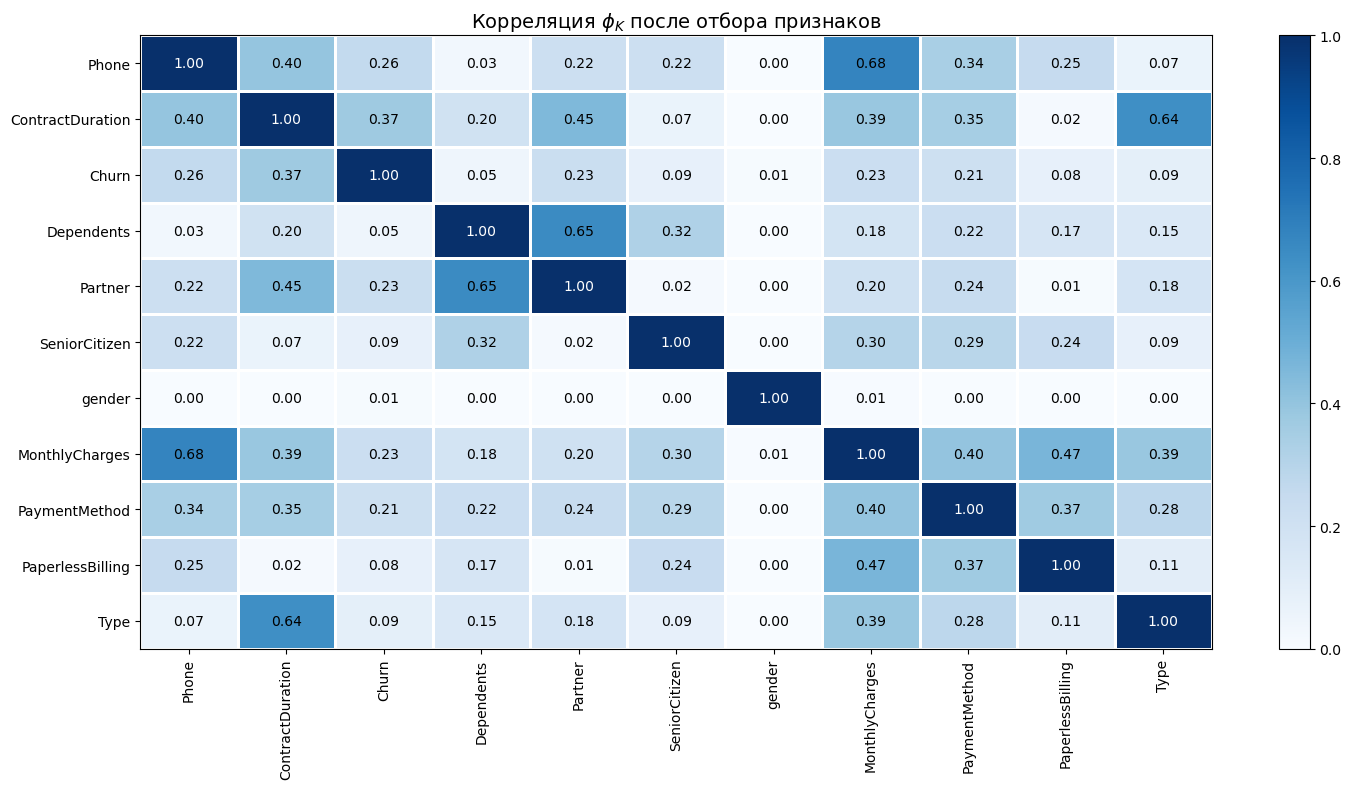

In [81]:
# построим график
plot_correlation_matrix(phik_overview_2.values, 
                        x_labels=phik_overview_2.columns, 
                        y_labels=phik_overview_2.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Корреляция $\phi_K$ после отбора признаков", 
                        fontsize_factor=1, 
                        figsize=(15, 8))
plt.tight_layout()

После обработки мультиколлинеарность признаков не превышает критическое значение. Продолжим работу с данным датасетом.

### Разделение датасета

Посмотрим на финальный датасет:

In [82]:
df_fin.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,gender,SeniorCitizen,Partner,Dependents,Churn,ContractDuration,Phone
0,Month-to-month,Yes,Electronic check,29.85,Female,0,Yes,No,1,31,0
1,One year,No,Mailed check,56.95,Male,0,No,No,1,1036,0
2,Month-to-month,Yes,Mailed check,53.85,Male,0,No,No,1,123,0
3,One year,No,Bank transfer (automatic),42.30,Male,0,No,No,1,1371,0
4,Month-to-month,Yes,Electronic check,70.70,Female,0,No,No,1,153,0


Разделим датасет на ``target`` и ``features``:

In [83]:
y = df_fin['Churn']
X = df_fin.drop(columns='Churn')

Разделим датасет на обучающую и тестовую выборки:

In [84]:
# сохраним пропорцию целевого признака в обучающей и тестовой выборках
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

Проверим разделение на выборки:

In [85]:
print('Размер обучающих выборок:', X_train.shape, y_train.shape)
print('Размер тестовых выборок:', X_test.shape, y_test.shape)

Размер обучающих выборок: (5274, 10) (5274,)
Размер тестовых выборок: (1758, 10) (1758,)


In [86]:
print('Доля положительного признака в таргете:', round(y_train.value_counts()[1] / len(y_train), 2), 'и', 
                                                 round(y_test.value_counts()[1] / len(y_test), 2))

print('Доля отрицательного признака в таргете:', round(y_train.value_counts()[0] / len(y_train), 2), 'и', 
                                                 round(y_test.value_counts()[0] / len(y_test), 2))

Доля положительного признака в таргете: 0.84 и 0.84
Доля отрицательного признака в таргете: 0.16 и 0.16


Выборки распределены корректно.

### Вывод

Предобработка датасета завершена. Можно переходить к обучению моделей.

## Обучение моделей

В данном разделе обучим модели (логистическую регрессию, случайный лес, LightGBM). Обучение будем проводить с помощью пайплайнов, кодируя признаки в рамках трансформеров, чтобы избежать утечки признаков. Оценку метрики будем проводить на кросс-валидации.

#### Логистическая регрессия

Для логистической регрессии и случайного леса проведем кодирование качественных признаков методом OHE. Также для регрессии проведем масштабирование.

In [87]:
# категориальные признаки для OHE
categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 
                        'SeniorCitizen', 'Partner', 'Dependents', 'Phone']

# количественные признаки для масштабирования
num_features = ['MonthlyCharges', 'ContractDuration']

In [88]:
# создаем трансформер для обработки колонок
col_transformer_lr = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        categorical_features
    ),
    (
        StandardScaler(),
        num_features
    )
)

In [89]:
# пайплайн для логистической регрессии
pipe_lr = Pipeline([
    ('col_transf', col_transformer_lr),
    ('lr_model', LogisticRegression())
])

In [90]:
# получим время обучения логистической регрессии
start = time.time()

pipe_lr.fit(X_train, y_train)

end = time.time()
lr_fit_time = end - start
print('Время обучения логистической регрессии:', round(lr_fit_time, 2), 'с')

Время обучения логистической регрессии: 0.04 с


In [91]:
roc_auc_lr = cross_val_score(pipe_lr, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1).mean()
print('ROC-AUC модели логистической регрессии:', round(roc_auc_lr, 2))

ROC-AUC модели логистической регрессии: 0.74


In [92]:
# время предсказания логистической регрессии
start = time.time()

pipe_lr.predict(X_train)

end = time.time()
lr_pred_time = end - start
print('Время предсказания логистической регрессии:', round(lr_pred_time, 2), 'с')

Время предсказания логистической регрессии: 0.02 с


Выведем сводную информацию по модели:

In [93]:
lr_results = pd.DataFrame({'Название модели': ['Логистическая регрессия'],
                           'ROC-AUC': [roc_auc_lr],
                           'Время обучения, с': [lr_fit_time],
                           'Время предсказания, с': [lr_pred_time],
                           'Используемые гиперпараметры': ['н/п']})
lr_results = lr_results.set_index('Название модели')
lr_results.style.format({'Время обучения, с': '{:.2f}', 'Время предсказания, с': '{:.2f}', 'ROC-AUC': '{:.2f}'})

,ROC-AUC,"Время обучения, с","Время предсказания, с",Используемые гиперпараметры
Название модели,,,,
Логистическая регрессия,0.74,0.04,0.02,н/п


#### Случайный лес

In [94]:
# пайплайн для Random Forest
pipe_rf = Pipeline([
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore')),
    ('rf_model', RandomForestClassifier(random_state=RANDOM_STATE))
])

In [ ]:
param_grid_rf = [
    {'rf_model__n_estimators': list(range(100, 301, 50)),
     'rf_model__max_depth': list(range(10, 29, 3))}
]

grid_rf = GridSearchCV(pipe_rf,
                      param_grid_rf,
                      scoring='roc_auc',
                      cv=3,
                      verbose=0,
                      refit=True)

grid_rf.fit(X_train, y_train)

In [96]:
grid_rf.best_params_

{'rf_model__max_depth': 25, 'rf_model__n_estimators': 200}

In [98]:
roc_auc_rf = grid_rf.best_score_
print('ROC-AUC модели случайного дерева:', round(roc_auc_rf, 2))

ROC-AUC модели случайного дерева: 0.88


In [99]:
# пайплайн для Random Forest с лучшими параметрами
pipe_rf = Pipeline([
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore')),
    ('rf_model', RandomForestClassifier(max_depth=22, n_estimators=250, random_state=RANDOM_STATE))
])

In [100]:
start = time.time()

pipe_rf.fit(X_train, y_train)

end = time.time()
rf_fit_time = end - start
print('Время обучения случайного дерева:', round(rf_fit_time, 2), 'с')

Время обучения случайного дерева: 0.61 с


In [101]:
start = time.time()

pipe_rf.predict(X_train)

end = time.time()
rf_pred_time = end - start
print('Время предсказания случайного дерева:', round(rf_pred_time, 2), 'с')

Время предсказания случайного дерева: 0.17 с


In [102]:
rf_results = pd.DataFrame({'Название модели': ['Случайный лес'],
                           'ROC-AUC': [roc_auc_rf],
                           'Время обучения, с': [rf_fit_time],
                           'Время предсказания, с': [rf_pred_time],
                           'Используемые гиперпараметры': [grid_rf.best_params_]})
rf_results = rf_results.set_index('Название модели')
rf_results.style.format({'Время обучения, с': '{:.2f}', 'Время предсказания, с': '{:.2f}', 'ROC-AUC': '{:.2f}'})

,ROC-AUC,"Время обучения, с","Время предсказания, с",Используемые гиперпараметры
Название модели,,,,
Случайный лес,0.88,0.61,0.17,"{'rf_model__max_depth': 25, 'rf_model__n_estimators': 200}"


#### LightGBM

In [103]:
# для модели градиентного бустинга изменим в датасетах тип качественных признаков на categorical
X_train_cat = X_train.copy()
X_test_cat = X_test.copy()

for dataset in [X_train_cat, X_test_cat]:
    for column in categorical_features:
        dataset[column] = dataset[column].astype('category')

Проверим корректность конвертации:

In [104]:
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 3126 to 6030
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              5274 non-null   category
 1   PaperlessBilling  5274 non-null   category
 2   PaymentMethod     5274 non-null   category
 3   MonthlyCharges    5274 non-null   float64 
 4   gender            5274 non-null   category
 5   SeniorCitizen     5274 non-null   category
 6   Partner           5274 non-null   category
 7   Dependents        5274 non-null   category
 8   ContractDuration  5274 non-null   int64   
 9   Phone             5274 non-null   category
dtypes: category(8), float64(1), int64(1)
memory usage: 165.9 KB


In [ ]:
gb_model = lgb.LGBMClassifier(random_state=RANDOM_STATE, 
                              importance_type='gain')

param_grid_gb = [
   {'num_leaves': [3, 4, 5], 
    'learning_rate': [0.26, 0.27, 0.28],
    'n_estimators': [600, 650, 700],
    'reg_alpha': [0.1, 0.15, 0.2],
    'reg_lambda': [0.5, 0.55, 0.6],
    'max_depth': [23, 24, 25],
    'subsample_for_bin': [3000, 3500, 4000],
    'min_data_in_leaf': [1, 10, 100]
   }]

grid_gb = GridSearchCV(gb_model,
                     param_grid_gb,
                     scoring='roc_auc',
                     cv=3,
                     verbose=0,
                     refit=True)

grid_gb.fit(X_train_cat, y_train)

In [117]:
grid_gb.best_params_

{'learning_rate': 0.27,
 'max_depth': 23,
 'min_data_in_leaf': 1,
 'n_estimators': 700,
 'num_leaves': 3,
 'reg_alpha': 0.2,
 'reg_lambda': 0.55,
 'subsample_for_bin': 4000}

In [118]:
# обучение модели с лучшими параметрами
gb_model = lgb.LGBMClassifier(n_estimators=700, num_leaves=3, learning_rate=0.27, reg_alpha=0.2,
                              reg_lambda=0.55, max_depth=23, subsample_for_bin=4000,
                              random_state=RANDOM_STATE, min_data_in_leaf=1,
                              importance_type='gain')

In [119]:
# время обучения
start = time.time()

gb_model.fit(X_train_cat, y_train)

end = time.time()
gb_fit_time = end - start
print('Время обучения градиентного бустинга:', round(gb_fit_time, 2), 'с')

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
Время обучения градиентного бустинга: 0.25 с


In [120]:
start = time.time()

predictions = gb_model.predict(X_train_cat)

end = time.time()
gb_pred_time = end - start
print('Время предсказания градиентного бустинга:', round(gb_pred_time, 2), 'с')

Время предсказания градиентного бустинга: 0.06 с


In [121]:
roc_auc_gb = grid_gb.best_score_
print('ROC-AUC модели градиентного бустинга:', round(roc_auc_gb, 2))

ROC-AUC модели градиентного бустинга: 0.91


In [122]:
gb_results = pd.DataFrame({'Название модели': ['LightGBM'],
                           'ROC-AUC': [roc_auc_gb],
                           'Время обучения, с': [gb_fit_time],
                           'Время предсказания, с': [gb_pred_time],
                           'Используемые гиперпараметры': [grid_gb.best_params_]})
gb_results = gb_results.set_index('Название модели')
gb_results.style.format({'Время обучения, с': '{:.2f}', 'Время предсказания, с': '{:.2f}', 'ROC-AUC': '{:.2f}'})

,ROC-AUC,"Время обучения, с","Время предсказания, с",Используемые гиперпараметры
Название модели,,,,
LightGBM,0.91,0.25,0.06,"{'learning_rate': 0.27, 'max_depth': 23, 'min_data_in_leaf': 1, 'n_estimators': 700, 'num_leaves': 3, 'reg_alpha': 0.2, 'reg_lambda': 0.55, 'subsample_for_bin': 4000}"


### Вывод 

Построим сводную таблицу с результатами обучения моделей:

In [123]:
summary_results = pd.concat([lr_results, rf_results, gb_results])
summary_results.style.format({'Время обучения, с': '{:.2f}', 'Время предсказания, с': '{:.2f}', 'ROC-AUC': '{:.2f}'})

,ROC-AUC,"Время обучения, с","Время предсказания, с",Используемые гиперпараметры
Название модели,,,,
Логистическая регрессия,0.74,0.04,0.02,н/п
Случайный лес,0.88,0.61,0.17,"{'rf_model__max_depth': 25, 'rf_model__n_estimators': 200}"
LightGBM,0.91,0.25,0.06,"{'learning_rate': 0.27, 'max_depth': 23, 'min_data_in_leaf': 1, 'n_estimators': 700, 'num_leaves': 3, 'reg_alpha': 0.2, 'reg_lambda': 0.55, 'subsample_for_bin': 4000}"


Мы видим, что лучшие результаты показали модели случайного леса и градиентного бустинга, при этом скорость работы модели градиентного бустинга также немного выше. В следующем разделе проверим эту модель на тестовой выборке.

## Проверка лучшей модели на тестовой выборке

Сделаем предсказания по тестовой выборке с помощью модели градиентного бустинга и посчитаем метрику ROC-AUC:

In [124]:
predictions_test = gb_model.predict(X_test_cat)
probabilities_test = gb_model.predict_proba(X_test_cat)
print('Метрика ROC-AUC на тестовой выборке:', round(roc_auc_score(y_test, probabilities_test[:, 1]), 2))

Метрика ROC-AUC на тестовой выборке: 0.92


Отобразим кривую ROC на графике:

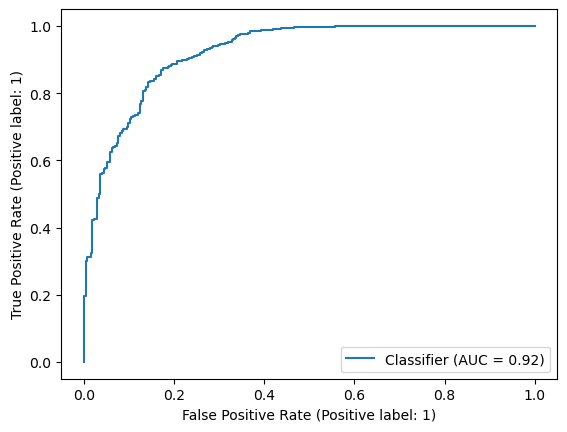

In [125]:
RocCurveDisplay.from_predictions(y_test, probabilities_test[:, 1])
plt.show()

Построим матрицу ошибок, а также нормализованную матрицу:

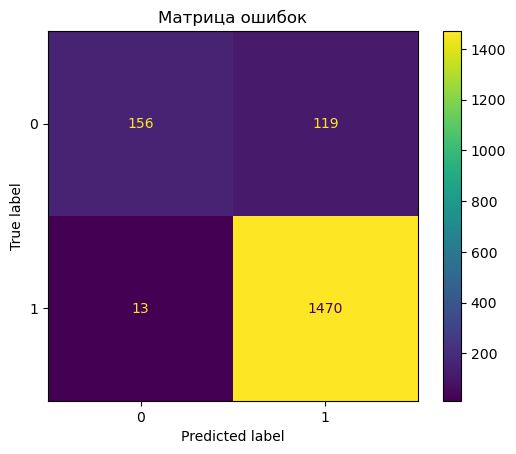

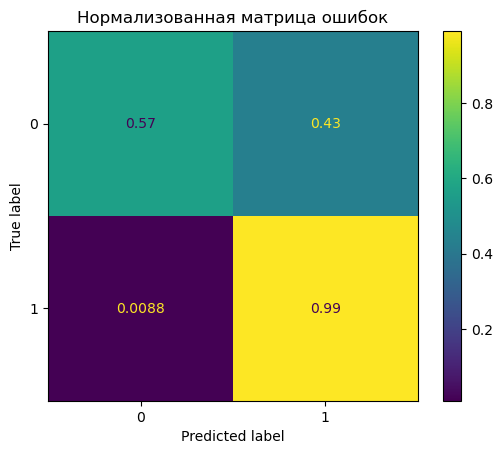

In [126]:
ConfusionMatrixDisplay.from_predictions(y_test, predictions_test)
plt.title('Матрица ошибок')
ConfusionMatrixDisplay.from_predictions(y_test, predictions_test, normalize='true')
plt.title('Нормализованная матрица ошибок')
plt.show()

Из приведенных выше графиков мы видим, что значение TPR составляет 0.99 при TNR равном 0.57, то есть модель лучше предсказывает клиентов, которые ушли, чем тех, с которыми контракт еще действует.
Иными словами, 43% клиентов, которые не собираются уходить, моделью будут распознаваться как клиенты, с которыми рекомендуется провести работу по удержанию.
Такие результаты модели можно объяснить тем, что в обучающей выборке гораздо лучше представлены уже ушедшие клиенты.

Для улучшения работы модели на реальных данных рекомендуется обучить ее на репрезентативных данных, в которых баланс классов был бы приближен к реальному в конкретный момент времени. Для этого можно было бы взять данные только по действующим клиентам на какой-то определенный момент времени в прошлом и пометить как уже ушедших клиентов тех, о которых известно, что они не стали продлевать договор на текущую дату.

Также посмотрим на важность параметров в модели:

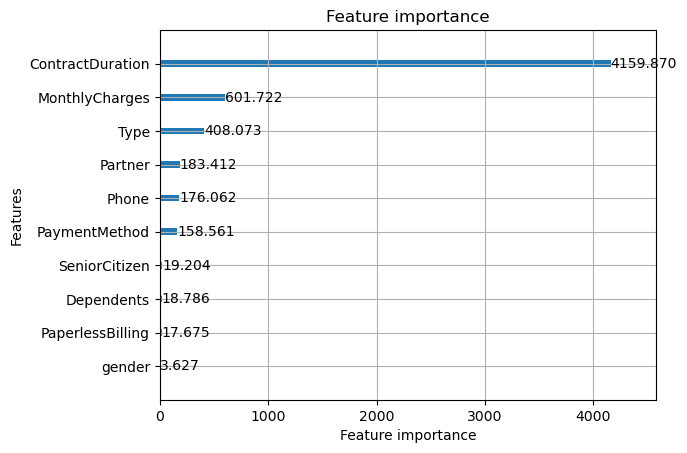

In [127]:
lgb.plot_importance(gb_model)
plt.show()

Как видно из графика выше, наиболее важными параметрами, влияющими на лояльность клиента, являются срок действия контракта, т. е. как давно клиент пользуется услугами компании, а также размер ежемесячной платы и тип оплаты. Это подтверждается исследованием признаков в разрезе ушедших и действующих клиентов, проведенным ранее. Значения этих признаков продемонстрировали наибольшие различия по двум группам клиентов.

## Вывод

В рамках данного проекта были проанализированы данные клиентов компании «Ниединогоразрыва.ком» с целью предсказания оттока клиентов.

Полученные данные были проанализированы и обработаны, и на их основе обучено несколько моделей классификации. По результатам кросс-валидации была выбрана лучшая модель - LightGBM, показавшая на тестовой выборке показатель ROC-AUC, равный 0.92.

Модель значительно лучше предсказывает ушедших клиентов, чем оставшихся, что связано с дисбалансом классов в обучающей выборке. Для улучшения модели в качестве обучающей выборке возможно обучение на датасете, который больше соответствует балансу классов клиентов в конкретный момент времени (более подробно описано в предыдущем разделе).

Наиболее важными параметрами, влияющими на отток клиентов, являются признаки "Длительность обслуживания клиента данной компанией", "Размер ежемесячной платы" и "Тип оплаты".

Таким образом, мы выполнили задачи и цель данного проекта.

## Отчет по решению

В данном разделе описаны ключевые этапы проекта.

### Анализ выполнения плана проекта

В данном разделе приведен анализ выполнения плана проекта, составленного на этапе исследовательского анализа данных.

Изначальный план содержал в себе следующие пункты:
1. Обработать сводный датасет и подготовить его к обучению модели.
2. Выбрать столбцы (параметры), актуальные для обучения модели, при необходимости создать новые.
3. Разделить данные на обучающую и тестовую выборки. 
4. Обучить несколько моделей классификации и сравнить их показатели на кросс-валидации по обучающей выборке.
5. Выбрать лучшую модель, проверить ее качество на тестовой выборке и представить результаты.


Все указанные выше изначально запланированные этапы работы были выполнены.

Также был проведен анализ всех признаков датасета в разрезе ушедших и оставшихся клиентов для более полного понимания данных, их стуктуры и взаимосвязи. Кроме того был проведен анализ на корреляцию признаков для избежания мультиколлинеарности, по результатом которого из датасета были удалены сильно коррелирующие друг с другом признаки.

### Трудности, возникшие при выполнении проекта

Наиболее сложным этапом проекта было достижение наибольшей метрики лучшей модели (LightGBM), а также избежание переобучения модели.

Решением стали тщательный анализ признаков, на которых обучается модель, а также подбор гиперпараметров модели, проводившийся в несколько итераций. Для начала были определены основные параметры и с помощью GridSearch выявлено их примерное значение, на которых метрика на кросс-валидации показывала наилучший результат. После были добавлены остальные параметры, в том числе те, которые помогали справиться с переобучением. После подбора приблизительных значений были подобраны наиболее точные значения параметров, которые позволяли улучшить итоговую метрику. Для ускорения подбора значения параметров поочередно фиксировались, после чего осуществлялся подбор следующего параметра. На финальном этапе был еще раз произведен совместный подбор на кросс-валидации среди всех отобранных параметров в рамках наилучших значений, полученных на предыдущем этапе.

Получившиеся значения параметров после этого были переданы в финальную модель, на которой рассчитывалось значение метрики на тестовой выборке.

### Ключевые шаги в решении задачи

В данном разделе перечислены и кратко описаны ключевые шаги решения.

#### Исследовательский анализ данных и объединение датасета

В качестве первого основного этапа проекта был проведен исследовательский анализ данных для знакомства с ними. Было уделено особое внимание признаку ``customerID``, по которому впоследствии планировалось объединить четыре исходных файла в сводный датасет. Значения данного признака были проверены на уникальность. При объединении файлов использовался способ объединения ``outer``, т. к. файлы ``Phone`` и ``Internet`` содержали не всех клиентов.

#### Анализ и обработка сводного датасета

После объединения датасет был проанализирован и предобработан.

В рамках данного этапа были заполнены явные и неявные (столбец ``TotalCharges``) пропуски, изменен тип данных для некоторых столбцов на более подходящий.

Был выделен целевой признак ``Churn`` на основе признака ``EndDate``. Клиенты, у которых отсутствовала дата завершения договора, были отнесены к действующим, прочие - к ушедшим. Также на данном этапе выявлена несбалансированность классов целевого признака.

Также был создан признак ``ContractDuration``, означающий продолжительность сотрудничества клиента с компанией и ``Phone``, обозначающий наличие либо отсутсвия у клиента услуг телефонии.

Далее был проведен анализ всех признаков в датасете в разрезе ушедших и действующих клиентов. Различия в большей части значений признаков не были существенными, основные различия были выявлены в распределениях значений признаков "Срок действия договора", "Размер ежемесячной оплаты" и "Тип оплаты". По итогам выделения ключевых параметров модели данные признаки показали наибольшую значимость. 

На последнем этапе данного шага был проведен анализ корреляции признаков с помощью библиотеки ``phik``. Для устранения мультиколлинеарности была удалена часть признаков. Оставшиеся признаки использовались для обучения моделей (подробное их описание см. в следующем разделе).

#### Обучение моделей

В рамках данного шага были обучены следующие модели: логистическая регрессия, случайный лес и градиентный бустинг LightGBM. Результаты моделей на обучающей метрике представлены ниже:

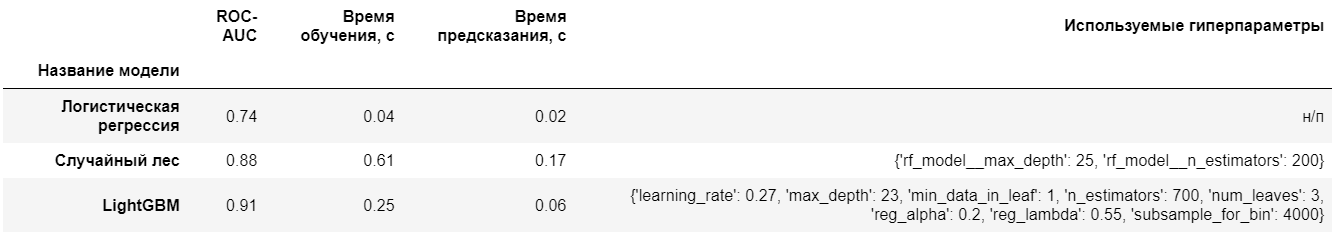

Наилучшие значения целевой метрики получены с помощью модели градиентного бустинга. Также у этой модели скорость обучения выше, чем у случайного леса, имеющей схожее значение метрики.

#### Проверка лучшей модели на тестовой выборке

На данном шаге модель LightGBM была проверена на тестовой выборке и сделаны выводы по модели (подробнее см. раздел "Итоговая модель" отчета).

### Признаки, использованные для обучения модели и их предобработка

Для обучения модели были использованы следующие признаки (в порядке появления в финальном датафрейме до разделения):
1. ``Type`` - тип оплаты. Предобработка не требовалась. Один из наиболее важных признаков в финальной модели.
2. ``PaperlessBilling`` - является ли платежный документ электронным. Предобработка не требовалась.
3. ``PaymentMethod`` - способ оплаты. Предобработка не требовалась.
4. ``MonthlyCharges`` - размер ежемесячной платы. Предобработка не требовалась. Один из наиболее важных признаков в финальной модели.
5. ``gender`` - пол клиента. Предобработка не требовалась.
6. ``SeniorCitizen`` - является ли клиент пенсионером. Предобработка не требовалась.
7. ``Partner`` - наличие супруга(и). Предобработка не требовалась.
8. ``Dependents`` - наличие иждивенцев. Предобработка не требовалась.
9. ``Churn`` - ушел ли клиент. Целевой признак. Создан на основе признака ``EndDate``.
10. ``ContractDuration`` - длительность действия договора в днях (до даты завершения договора в случае ушедших клиентов, либо до даты выгрузки данных (01.02.2020) в случае действующих клиентов. Создан как разность признаков ``EndDate`` (либо даты выгрузки) и ``BeginDate``. Наиболее важный признак в финальной модели.
11. ``Phone`` - пользуется ли клиент услугами телефонии от компании. Создан на основе признака ``MultipleLines`` (пропуск соответствует значению ``0``, ``Yes`` либо ``No`` значению ``1``).

Таким образом в финальном датасете не использовались признаки из файла ``Internet`` ввиду их высокой мультиколлинеарности. При удалении данных признаков мы исходили из предположения, что набор услуг интернета заложен в размере ежемесячного платежа (признак ``MonthlyCharges``).

### Итоговая модель

В данном разделе описана финальная модель и ее показатели.

В качестве лучшей модели была выбрана модель градиентного бустинга LightGBM. Ниже перечислены ее гиперпараметры:
- ``learning_rate`` (скорость обучения) - 0.27
- ``max_depth`` (максимальная глубина деревьев в составе модели) - 23
- ``min_data_in_leaf`` (минимальное количество наблюдений в каждом узле дерева) - 1
- ``n_estimators`` (количество моделей деревьев) - 700
- ``num_leaves`` (максимальное количество листьев в составе дерева) - 3
- ``reg_alpha`` (L1 регуляризация) - 0.2
- ``reg_lambda`` (L2 регуляризация) - 0.55
- ``subsample_for_bin`` (количество наблюдений для разбивки признаков на "корзины") - 4000.

Значение метрики ROC-AUC на тестовой выборке составило 0.92. Ниже приведен график ROC, а также нормализованная матрица ошибок:

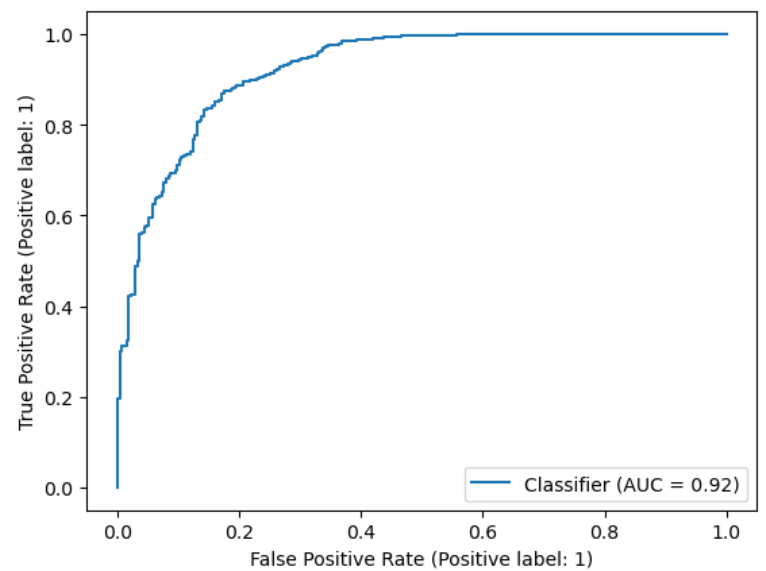

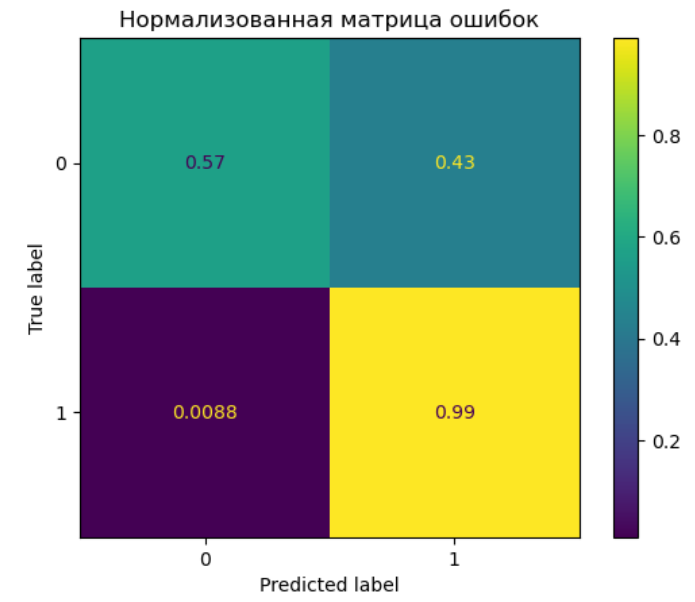

Из приведенных графиков видно, что значение TPR составляет 0.99 при TNR равном 0.57, то есть модель лучше предсказывает клиентов, которые ушли, чем тех, с которыми контракт еще действует.
Так, 43% клиентов, которые не собираются уходить, моделью будут распознаваться как клиенты, с которыми рекомендуется провести работу по удержанию.
Такие результаты модели можно объяснить тем, что в обучающей выборке гораздо лучше представлены уже ушедшие клиенты.

Также ниже приведена важность признаков модели:

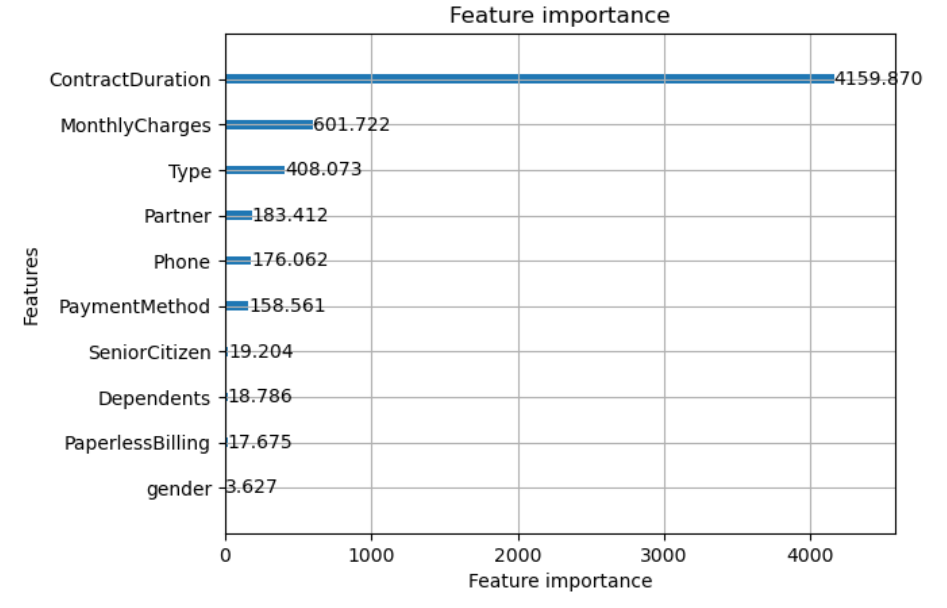

Наиболее важными параметрами модели являются срок действия контракта, т. е. как давно клиент пользуется услугами компании, а также размер ежемесячной платы и тип оплаты. Это подтверждается исследованием признаков в разрезе ушедших и действующих клиентов (значения этих признаков продемонстрировали наибольшие различия по двум группам клиентов).

### Вывод

В приведенном отчете рассмотрены основные этапы проекта, выполнение изначального плана, описаны возникшие сложности. Также описаны признаки, отобранные для обучения моделей, и их предобработка, обозначены показатели наилучшей модели. Цель и задачи проекта выполнены.